In [1]:
import numpy as np
import pandas as pd
import datetime
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from scipy import stats
from math import sqrt
#from ipynb.fs.full.get_scoring_measures import get_scoring_measures
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
%matplotlib inline
%run ./../custom_functions/get_scoring_measures.ipynb

In [2]:
# Extracting the data of both frequencies (high and daily)

ARIMA_OF_results = pd.read_csv('./../../../Databases/results_data/ARIMA_results.csv', index_col = 'Timestamp')
ARIMA_DF_results = pd.read_csv('./../../../Databases/results_data/ARIMA_dailyresults.csv', index_col = 'Timestamp')
ARIMA_OF_confint = pd.read_csv('./../../../Databases/results_data/ARIMA_confint.csv', index_col = 'Timestamp')
ARIMA_DF_confint = pd.read_csv('./../../../Databases/results_data/ARIMA_dailyconfint.csv', index_col = 'Timestamp')
ARIMA_OF_runtime = pd.read_csv('./../../../Databases/results_data/ARIMA_runtime_scenarios.csv')
ARIMA_DF_runtime = pd.read_csv('./../../../Databases/results_data/ARIMA_runtime_dailyscenarios.csv')

## Original frequency anaylsis

As in the previous notebook, the analysis will be conducted on the results extracted from the Maragall data. It was not possible to extract results from the unknown future (creating lags along each prediction) using external data as exogenous.

In [3]:
ARIMA_OF_results.head()

,Observed_values,TotEntr_PKF_allcols,TotEntr_PKF_lags,TotEntr_PUF_lags,TotEntr_noexo
Timestamp,,,,,
2018-09-24 00:00:00,20,4.183628,-1.160668,-1.160668,40.376416
2018-09-24 00:30:00,0,-3.999364,-7.325107,-18.933325,23.993877
2018-09-24 01:00:00,0,-13.922692,-14.139623,-27.434277,35.631315
2018-09-24 01:30:00,0,-25.213029,-25.625291,-38.792805,27.798463
2018-09-24 02:00:00,0,-6.003513,-5.980766,-28.479983,39.318221


In [20]:
# All_cols regressors: 340    Justlags regressors: 336   Because of how the custom function is coded, 
# the scorings of the Noexo_data have to be calculated separately.  

ARIMA_scorings = get_scoring_measures(ARIMA_OF_results.drop('TotEntr_noexo', axis=1), 7*48,340)

In [23]:
Noexo_RMSE = np.sqrt(mean_squared_error(ARIMA_OF_results['Observed_values'], ARIMA_OF_results['TotEntr_noexo']))
Noexo_R2 = r2_score(ARIMA_OF_results['Observed_values'], ARIMA_OF_results['TotEntr_noexo'])
Noexo_R2_adj = (1 - (1 - Noexo_R2)) * ((ARIMA_OF_results.shape[0] - 1)/(ARIMA_OF_results.shape[0] - 1))
Noexo_df = pd.concat([pd.DataFrame(pd.Series([Noexo_RMSE], name='RMSE')), pd.DataFrame(pd.Series([Noexo_R2_adj], name='R2_adjusted'))], axis=1)
Noexo_df.index = ['Noexo']
pd.concat([ARIMA_scorings, Noexo_df])

,RMSE,R2_adjusted
TotEntr_PKF_allcols,28.561743,0.988317
TotEntr_PKF_lags,28.600972,0.987592
TotEntr_PUF_lags,103.224281,0.265640
Noexo,169.749885,-1.018589


The results obtained using lags of future observations (introducing future information in the forecasting process) yields a much better result than forecasting without including that information. Predicting the unknown, there's an important difference between including exogenous data (which improves the results) and just making predictions with no exogenous data, both in terms of RMSE and R2_adjusted.

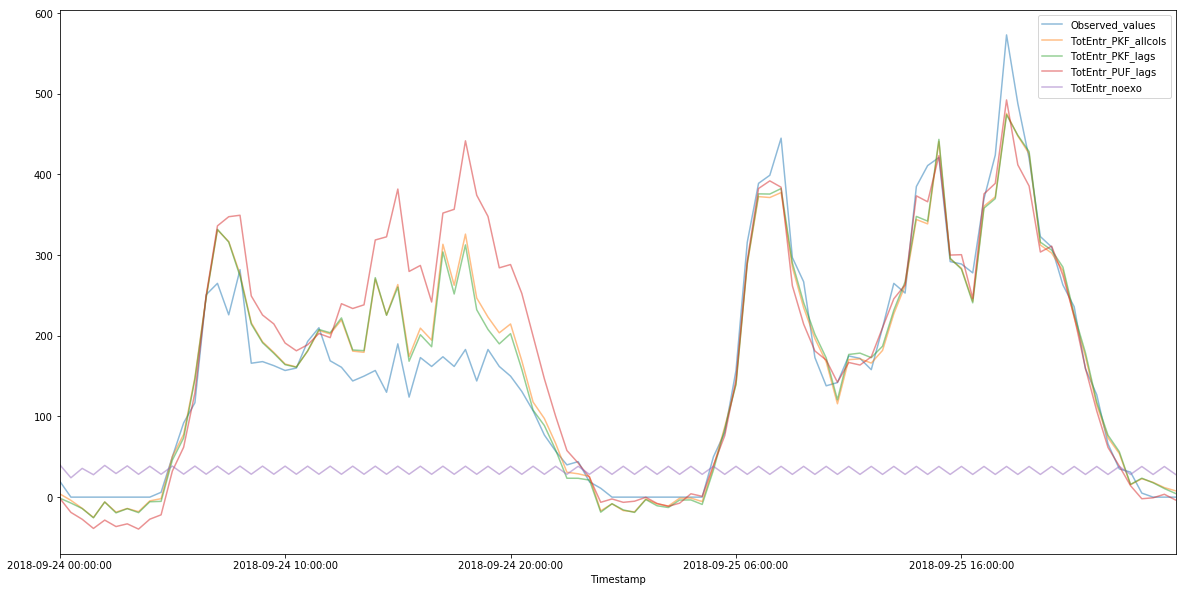

In [7]:
# Let's plot the first 100 predictions vs. the observed values to get an idea
# of the differences.

ax = ARIMA_OF_results[:100].plot(figsize=(20,10), alpha=0.5, legend=True)
plt.show()

The plot helps to get a good intuition of the reason behind the bad results of not using exogenous data. When using lags of future observations, including external data doesn't seem to make a difference (as seen both on the plot and the results).

The best model predicting unknown data is the one that uses lags, TotEntr_PUF_lags. From now on, the results of that model will be the ones analyzed.

### Residuals analysis

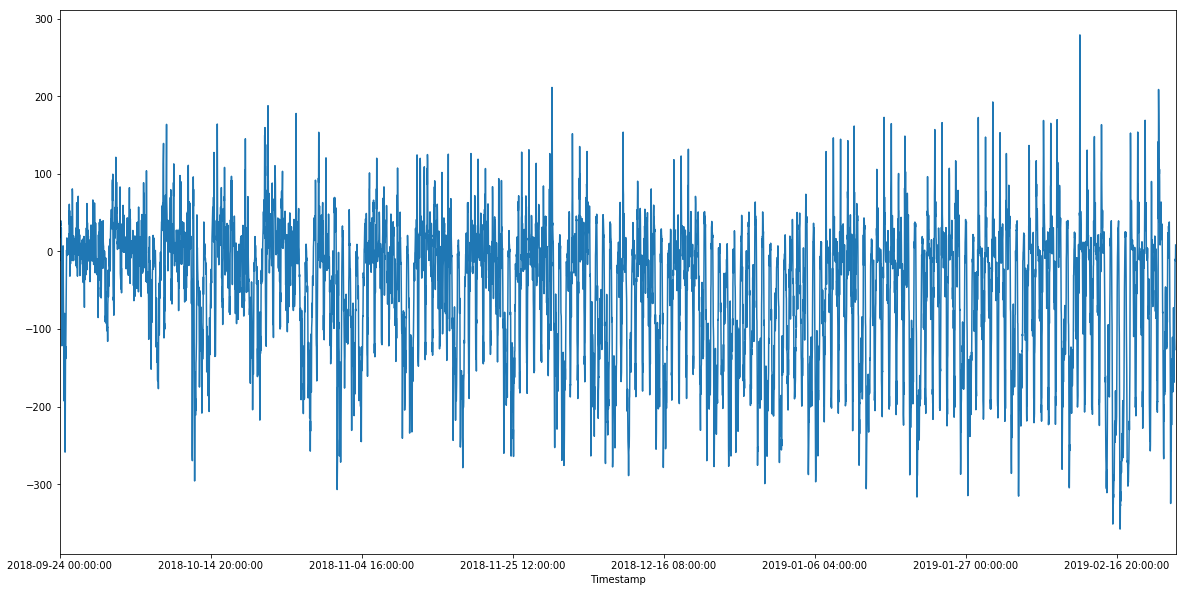

In [8]:
# Let's plot the residuals to see if there's a visible pattern:

ARIMA_residuals = ARIMA_OF_results['Observed_values'] - ARIMA_OF_results['TotEntr_PUF_lags']

ARIMA_residuals.plot(figsize=(20,10))
plt.show()

Besides an alternating cycle of peaks and valleys, there seem to be a trend of growing variance of residuals over time.

In [37]:
ARIMA_residuals.describe()

count    7392.000000
mean      -52.119588
std        89.105975
min      -357.949268
25%      -116.785657
50%       -26.871078
75%        11.848476
max       279.115629
dtype: float64

As in the case of linear regression, there's a bias towards negative values.

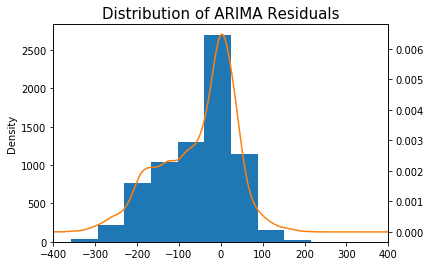

In [38]:
# Histogram and density of residuals

ax = ARIMA_residuals.hist()
ARIMA_residuals.plot(kind='kde', ax=ax, secondary_y=True, xlim=(-400,400))
plt.title('Distribution of ARIMA Residuals', fontsize=15)
plt.show()

The density plot shows a skewed distribution of residuals towards negative values.

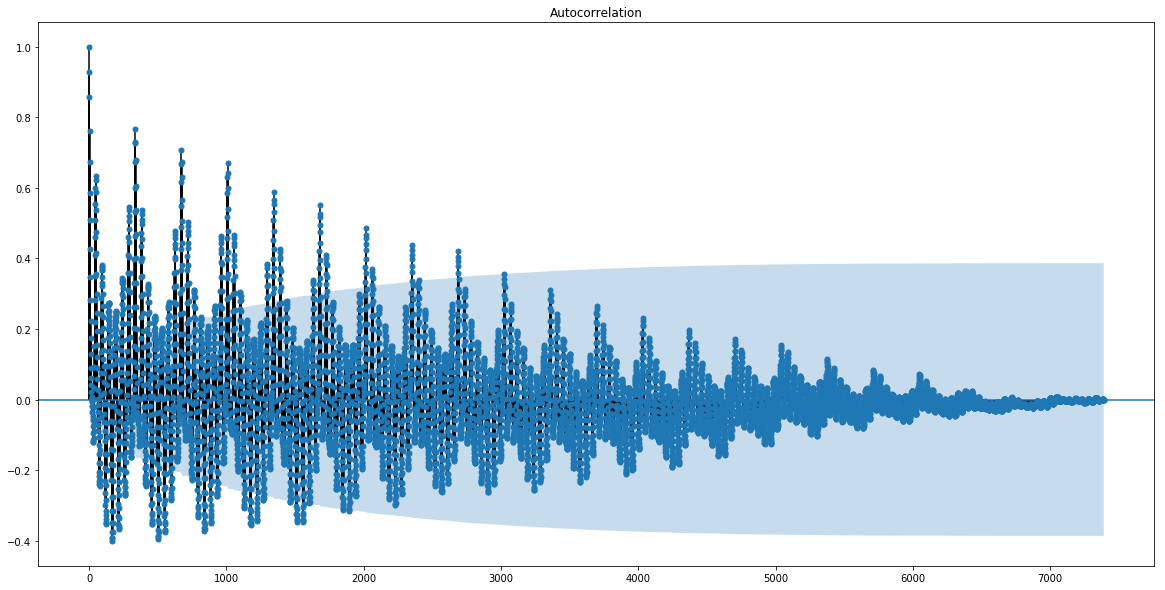

In [10]:
# Autocorrelation plot

from statsmodels.graphics.tsaplots import plot_acf
with plt.rc_context():
    plt.rc("figure", figsize=(20,10))
    plot_acf(ARIMA_residuals)

The autocorrelation plot shows a cyclical pattern.

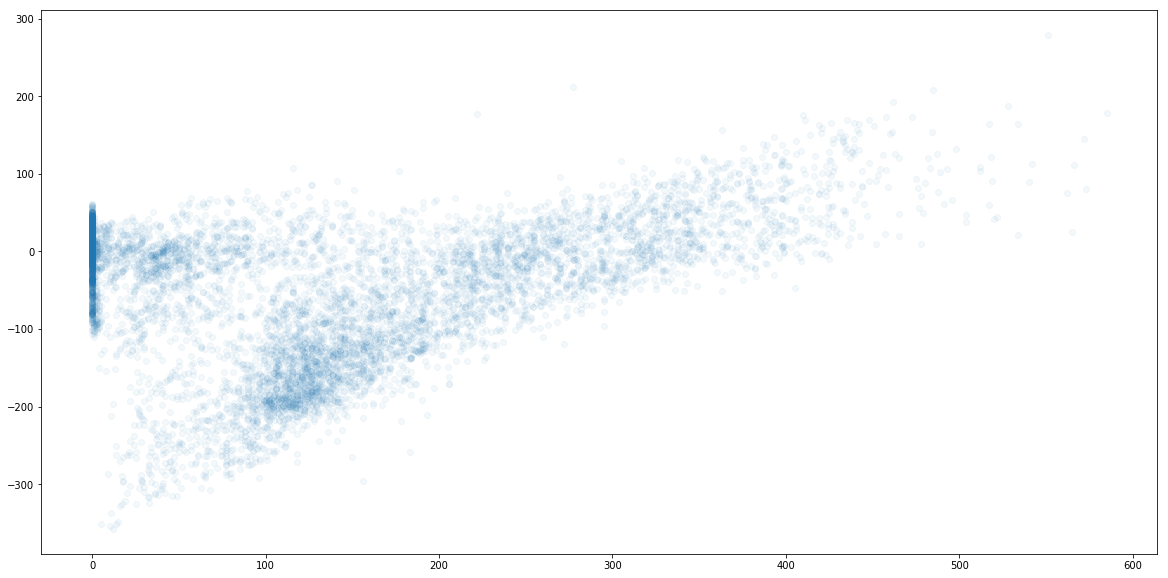

In [11]:
# Plotting residuals against fitted values:

plt.figure(figsize=(20,10))
plt.scatter(ARIMA_OF_results['Observed_values'], ARIMA_residuals, alpha=0.05)
plt.show()

The plot of observations vs. residuals shows a positive trend revealing that the bigger the observations, the closer the residuals get to the 'positive' zone on the right.

In [12]:
# Let's estimate the scoring when predicting time windows of different length into the future:

ARIMA_future_scoring = pd.DataFrame

for i in [1, 3, 7, 10, 12, 15]:
    if ARIMA_future_scoring.empty:
        ARIMA_future_scoring = pd.DataFrame(pd.Series(np.sqrt(mean_squared_error(ARIMA_OF_results['Observed_values'][:48], ARIMA_OF_results['TotEntr_PUF_lags'][:48])), name = (str(i) + '-day')))

    else:
        ARIMA_future_scoring = pd.concat([ARIMA_future_scoring, pd.DataFrame(pd.Series(np.sqrt(mean_squared_error(ARIMA_OF_results['Observed_values'][:48*i], ARIMA_OF_results['TotEntr_PUF_lags'][:48*i])), name = (str(i) + '-day')))], axis=1)


ARIMA_future_scoring = pd.DataFrame(ARIMA_future_scoring.values.reshape(-1, 1), 
                                    index=list(ARIMA_future_scoring.columns), 
                                    columns=['ARIMA_RMSE'])


ARIMA_future_R2_df = pd.DataFrame

for i in [1, 3, 7, 10, 12, 15]:
    if ARIMA_future_R2_df.empty:
        ARIMA_future_R2_df = pd.DataFrame(pd.Series(r2_score(ARIMA_OF_results['Observed_values'][:48], ARIMA_OF_results['TotEntr_PUF_lags'][:48]), name = (str(i) + '-day')))
        
    else:
        ARIMA_future_R2_df = pd.concat([ARIMA_future_R2_df, pd.DataFrame(pd.Series(r2_score(ARIMA_OF_results['Observed_values'][:48*i], ARIMA_OF_results['TotEntr_PUF_lags'][:48*i]), name = (str(i) + '-day')))], axis=1)
        
ARIMA_future_R2_df = pd.DataFrame(ARIMA_future_R2_df.values.reshape(-1, 1), index=list(ARIMA_future_R2_df.columns), columns=['R2'])

ARIMA_future_R2_df['ARIMA_R2_adj'] = (1 - (1 - ARIMA_future_R2_df['R2'])) * ((ARIMA_OF_results.shape[0] - 1)/(ARIMA_OF_results.shape[0] - 336 - 1))
ARIMA_future_scoring = pd.concat([ARIMA_future_scoring, ARIMA_future_R2_df['ARIMA_R2_adj']], axis=1)
ARIMA_future_scoring

,ARIMA_RMSE,ARIMA_R2_adj
1-day,101.847780,-0.673617
3-day,61.815654,0.852521
7-day,49.582325,0.916061
10-day,46.783813,0.938236
12-day,44.827144,0.951573
15-day,51.243740,0.913741


The time window that yields the best RMSE and R2_adj would be the first 12 days. Let's plot the distribution of absolute errors along them:

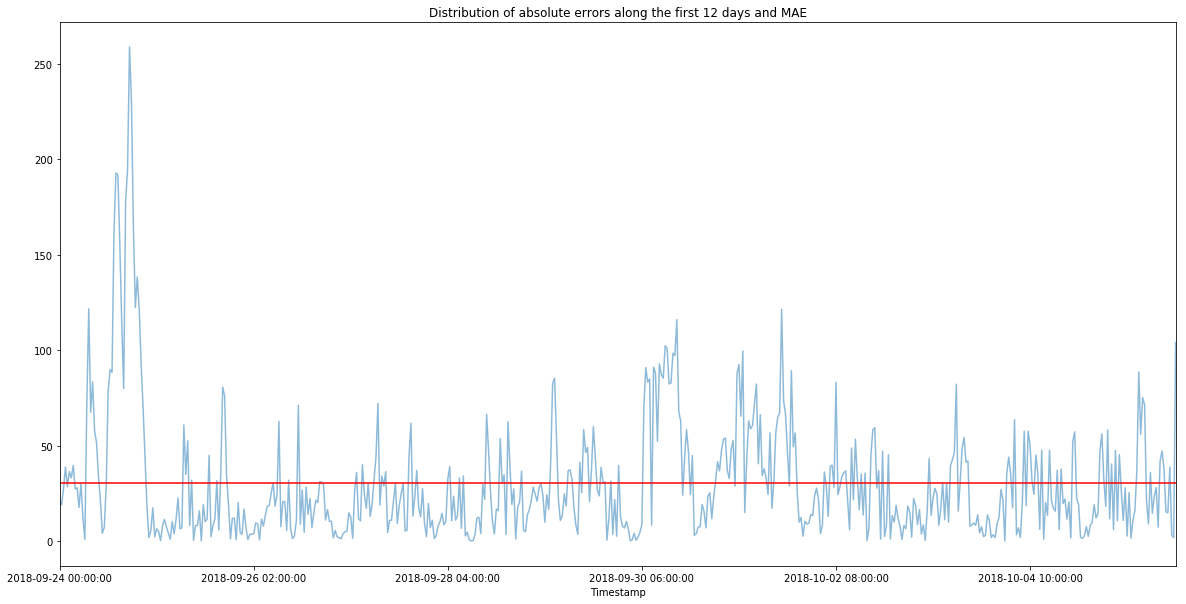

In [13]:
ax = abs(ARIMA_OF_results['Observed_values'] - ARIMA_OF_results['TotEntr_PUF_lags'])[:48*12].plot(figsize=(20,10), alpha=0.5, title='Distribution of absolute errors along the first 12 days and MAE')
plt.plot([mean_absolute_error(ARIMA_OF_results['Observed_values'][:48*12], ARIMA_OF_results['TotEntr_PUF_lags'][:48*12]) for e in range(48*12)], color='red')
plt.show()

The first day shows the biggest errors along the plot, and there's another peak on the 6th and 7th day.

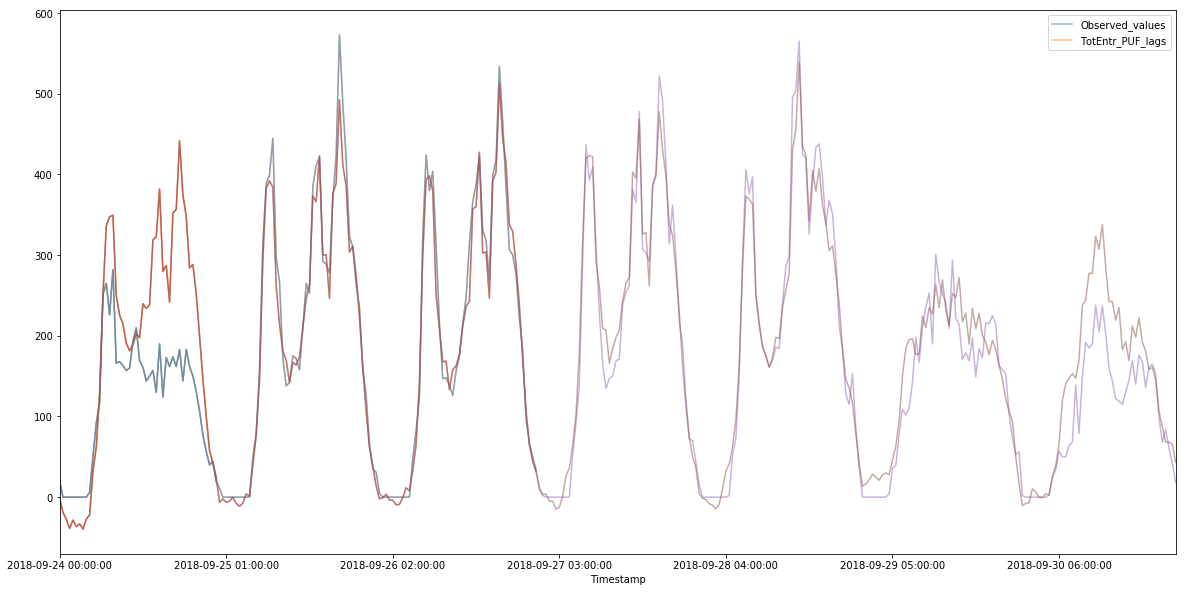

In [14]:
# Plotting observed vs. predicted along the first week

ax = ARIMA_OF_results[['Observed_values', 'TotEntr_PUF_lags']][:48].plot(figsize=(20,10), alpha=0.5, legend=True)
ARIMA_OF_results[['Observed_values', 'TotEntr_PUF_lags']][:48*3].plot(figsize=(20,10), alpha=0.5, legend=False, ax = ax)
ARIMA_OF_results[['Observed_values', 'TotEntr_PUF_lags']][:48*7].plot(figsize=(20,10), alpha=0.5, legend=False, ax = ax)

plt.show()

There's a noticeable difference on the predictions of the first day vs. the observed values. From day 2 and on, the predictions seem to adapt quite well to the observations.

## Daily frequency anaylsis

In [15]:
ARIMA_DF_results.head()

,Observed_values,DayEntr_PKF_allcols,DayEntr_PKF_lags,DayEntr_PUF_allcols,DayEntr_PUF_lags,DayEntr_noexo
Timestamp,,,,,,
2018-09-24,5719,9265.802845,9516.854425,9.265803e+03,9516.854425,8148.180530
2018-09-25,9998,8657.545503,9135.138861,1.508744e+07,9784.049681,8898.529572
2018-09-26,9816,9453.451855,10047.471310,-2.473273e+10,9794.004218,8567.972420
2018-09-27,10087,9591.111601,10130.052655,-1.648085e+12,10360.092022,8194.394256
2018-09-28,10742,10171.307107,10093.401038,-6.181053e+13,10238.413244,8164.736295


The results extracted predicting unknown future and allcols seem to be very extreme. That may result in errors on the scoring calculations.

In [16]:
# Allcols regressors: 10    Justlags regressors: 7

get_scoring_measures(ARIMA_DF_results, 7, 10)

/home/quark/anaconda3/envs/mpro/lib/python3.6/site-packages/sklearn/metrics/regression.py:241: RuntimeWarning: overflow encountered in square
  output_errors = np.average((y_true - y_pred) ** 2, axis=0,
/home/quark/anaconda3/envs/mpro/lib/python3.6/site-packages/sklearn/metrics/regression.py:543: RuntimeWarning: overflow encountered in square
  numerator = (weight * (y_true - y_pred) ** 2).sum(axis=0,


,RMSE,R2_adjusted
DayEntr_PKF_allcols,1247.954100,0.741954
DayEntr_PKF_lags,1581.703392,0.531912
DayEntr_PUF_allcols,inf,-inf
DayEntr_PUF_lags,2984.880780,-0.789784
DayEntr_noexo,2995.057667,-0.819169


As expected, infinite values are shown when estimating RMSE and R2_adj of the results for 'unknown' future using all columns. When comparing the use of lags vs. the lack of exogenous data, it can be observed that using exogenous data leads to better results in terms of RMSE, though the difference is very small. In terms of R2_adjusted, no amount of variance is explained in one scenario or the other.

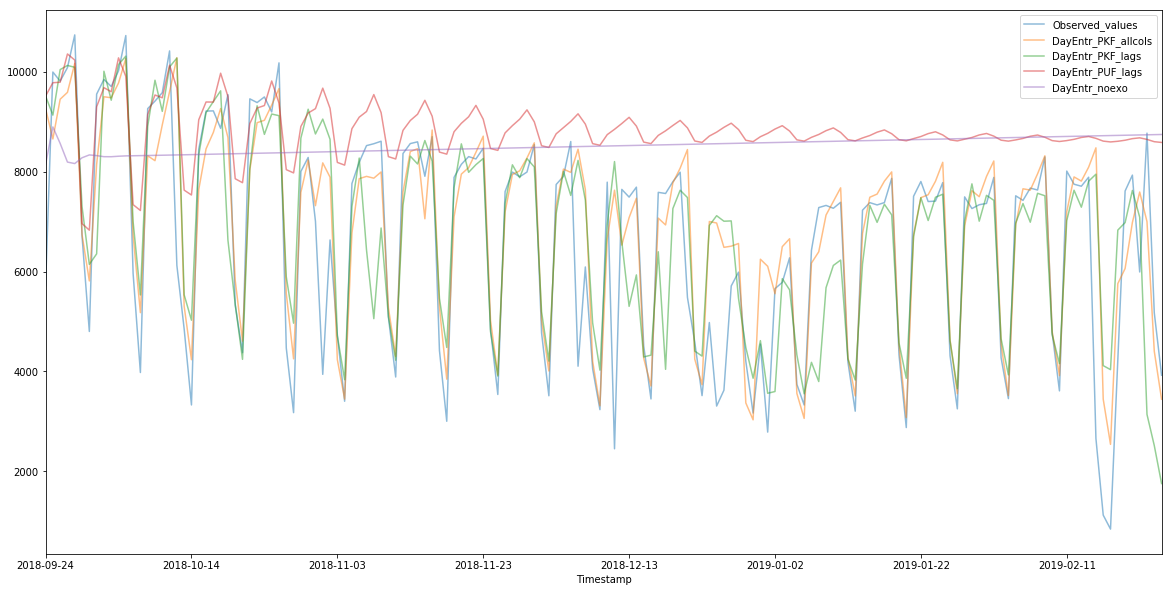

In [22]:
# Let's plot the observed values vs. all the scenarios:

ax = ARIMA_DF_results.drop('DayEntr_PUF_allcols', axis = 1).plot(figsize=(20,10), alpha=0.5, legend=True)
plt.show()

The plot shows that the only unknown future predicting model that captures some of the information shown on the observations is the one that uses lags. It fails to capture the valleys, and that handicap increases over time (after 1 month the signal is almost lost).

## Comparison of results by resolution

In [62]:
# Grouping predictions by day: comparing observed vs. 48 obs/day vs. daily observations.

obs_preds_grouped = ARIMA_OF_results['Observed_values']
obs_preds_grouped.index = pd.to_datetime(obs_preds_grouped.index)
obs_preds_grouped = obs_preds_grouped.groupby(pd.Grouper(freq='D')).sum()

est_preds_grouped = ARIMA_OF_results['TotEntr_PUF_lags']
est_preds_grouped.index = pd.to_datetime(est_preds_grouped.index)
est_preds_grouped = est_preds_grouped.groupby(pd.Grouper(freq='D')).sum()

grouped_predictions = pd.concat([pd.DataFrame(pd.Series(obs_preds_grouped, name='obs_vals')), pd.DataFrame(pd.Series(est_preds_grouped, name='est_preds_48/day'))], axis=1)
grouped_predictions = pd.concat([grouped_predictions, ARIMA_DF_results['DayEntr_PUF_lags']], axis=1)
grouped_predictions.head(10)

,obs_vals,est_preds_48/day,DayEntr_PUF_lags
Timestamp,,,
2018-09-24,5719,8698.671306,9516.854425
2018-09-25,9998,9425.502861,9784.049681
2018-09-26,9816,9600.559363,9794.004218
2018-09-27,10087,10364.047494,10360.092022
2018-09-28,10742,10400.435382,10238.413244
2018-09-29,6706,7353.807276,6961.997684
2018-09-30,4801,6707.360486,6830.571482
2018-10-01,9555,8243.583999,9302.609663
2018-10-02,9850,9190.728495,9685.054132


In [51]:
get_scoring_measures(grouped_predictions, 336, 7, comparing_resolution=True)

,RMSE,R2_adjusted
est_preds_48/day,3386.045008,1.050687
DayEntr_PUF_lags,2984.880780,-0.789784


In [52]:
# Estimating the total RMSE and R2_adjusted for windows of diferent span:

for x in [1, 3, 7, 10]:
    print(get_scoring_measures(grouped_predictions[:x], 336, 7, comparing_resolution=True), str(x)+'-days')
    print('-'*50)

                         RMSE  R2_adjusted
est_preds_48/day  2979.671306         -0.0
DayEntr_PUF_lags  3797.854425         -0.0 1-days
--------------------------------------------------
                         RMSE  R2_adjusted
est_preds_48/day  1756.189885    -0.001256
DayEntr_PUF_lags  2196.205575     0.094300 3-days
--------------------------------------------------
                         RMSE  R2_adjusted
est_preds_48/day  1388.724749    -0.011321
DayEntr_PUF_lags  1646.764398    -2.816383 7-days
--------------------------------------------------
                         RMSE  R2_adjusted
est_preds_48/day  1257.109753    -0.016692
DayEntr_PUF_lags  1381.482962     2.361495 10-days
--------------------------------------------------


The RMSE shows better scorings in each time window. The R2_adj could be considered as 0 on the first windows but on the daily scenario, and a window of 10 days, there's a peak.

In [57]:
# Estimating the total RMSE and R2_ajd for specific days in the future:

for x in [1, 3, 7, 10]:
    print(get_scoring_measures(grouped_predictions[x-1:x], 336, 7, comparing_resolution=True), str(x)+'-days')
    print('-'*50)

                         RMSE  R2_adjusted
est_preds_48/day  2979.671306         -0.0
DayEntr_PUF_lags  3797.854425         -0.0 1-days
--------------------------------------------------
                        RMSE  R2_adjusted
est_preds_48/day  215.440637         -0.0
DayEntr_PUF_lags   21.995782         -0.0 3-days
--------------------------------------------------
                         RMSE  R2_adjusted
est_preds_48/day  1906.360486         -0.0
DayEntr_PUF_lags  2029.571482         -0.0 7-days
--------------------------------------------------
                        RMSE  R2_adjusted
est_preds_48/day  385.880117         -0.0
DayEntr_PUF_lags  105.890722         -0.0 10-days
--------------------------------------------------


The first day of predictions shows the biggest error in comparison with other days. Care should be taken considering the predictions, since the size of the errors on the 3rd and 10th day seems to be not too big, but then there's a big deviation on the 7th day. It is worth mentioning that although when increasing the window span the high frequency scenario shows better scorings, taht's not the case as when considering specific days (where in some cases the daily model is better).

In [111]:
RMSE_comparison_df = pd.DataFrame
RMSE_48_df = pd.DataFrame 
RMSE_daily = pd.DataFrame



for i in range(1,15):
    if RMSE_48_df.empty:
        RMSE_48_df = pd.DataFrame(pd.Series(np.sqrt(mean_squared_error(grouped_predictions['obs_vals'][:1], grouped_predictions['est_preds_48/day'][:1])), name = 'RMSE-48')) 
        RMSE_daily = pd.DataFrame(pd.Series(np.sqrt(mean_squared_error(grouped_predictions['obs_vals'][:1], grouped_predictions['DayEntr_PUF_lags'][:1])), name = 'RMSE-daily'))
        
    else:
        RMSE_48_df = pd.concat([RMSE_48_df, pd.DataFrame(pd.Series(np.sqrt(mean_squared_error(grouped_predictions['obs_vals'][i-1:i], grouped_predictions['est_preds_48/day'][i-1:i])), name = 'RMSE-48'))])
        RMSE_daily = pd.concat([RMSE_daily, pd.DataFrame(pd.Series(np.sqrt(mean_squared_error(grouped_predictions['obs_vals'][i-1:i], grouped_predictions['DayEntr_PUF_lags'][i-1:i])), name = 'RMSE-daily'))])
       
        
RMSE_comparison_df = pd.concat([RMSE_48_df, RMSE_daily], axis = 1)
RMSE_comparison_df.index = obs_preds_grouped[:len(RMSE_daily)].index

RMSE_comparison_df

,RMSE-48,RMSE-daily
Timestamp,,
2018-09-24,2979.671306,3797.854425
2018-09-25,572.497139,213.950319
2018-09-26,215.440637,21.995782
2018-09-27,277.047494,273.092022
2018-09-28,341.564618,503.586756
2018-09-29,647.807276,255.997684
2018-09-30,1906.360486,2029.571482
2018-10-01,1311.416001,252.390337
2018-10-02,659.271505,164.945868


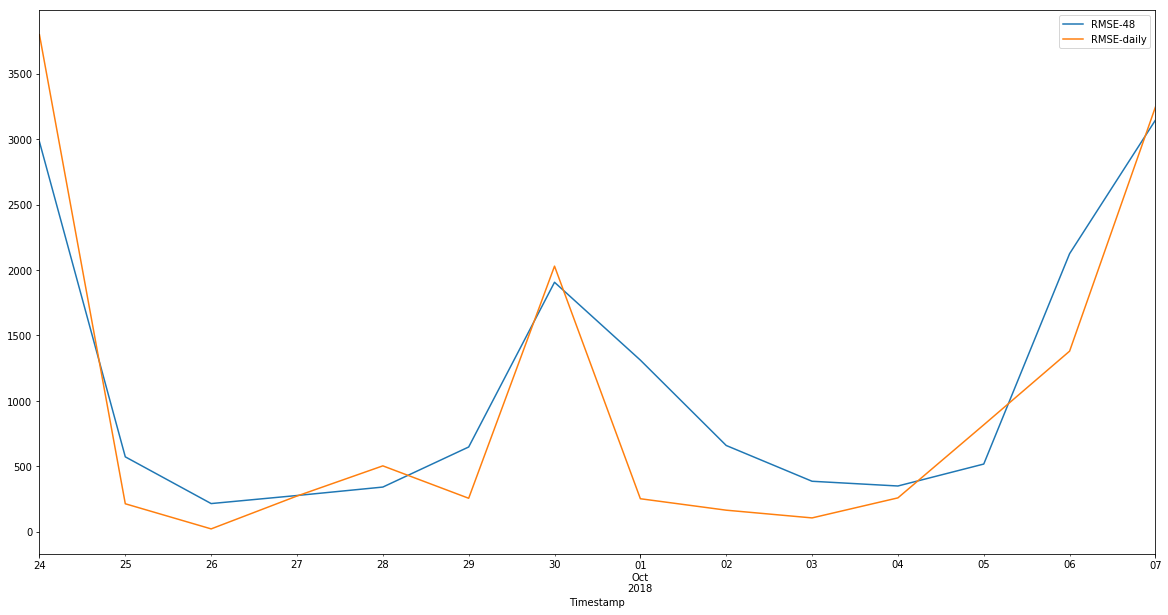

In [113]:
# Let's plot the RMSE of the 2 models (daily and 48 predictions) of the first 14 days:

ax = RMSE_comparison_df.plot(figsize=(20,10), legend=True)
plt.show()

There's not a predominance of one model over the other for the first 14 days when considering the minimal RMSE.

## Computing cost

In [4]:
ARIMA_OF_runtime.columns, ARIMA_DF_runtime.columns

(Index(['PKF_allcols_ARIMA_runtime', 'PKF_lags_ARIMA_runtime',
        'PUF_lags_ARIMA_runtime', 'noexo_ARIMA_runtime'],
       dtype='object'),
 Index(['daily_PKF_allcols_ARIMA_runtime', 'daily_PKF_lags_ARIMA_runtime',
        'daily_PUF_allcols_ARIMA_runtime', 'daily_PUF_lags_ARIMA_runtime',
        'noexo_dARIMA_runtime'],
       dtype='object'))

In [21]:
# Let's create a data frame cotanining all computing costs. In order to do so, first we have to rename
# the columns of the dataframes of both frequencies, taking into acount that they are of different shape:

ARIMA_DF_runtime.rename(columns = {'daily_PKF_allcols_ARIMA_runtime':'PKF_allcols_ARIMA_runtime', 'daily_PKF_lags_ARIMA_runtime':'PKF_lags_ARIMA_runtime',
            'daily_PUF_allcols_ARIMA_runtime': 'PUF_allcols_ARIMA_runtime', 'daily_PUF_lags_ARIMA_runtime':'PUF_lags_ARIMA_runtime',
            'noexo_dARIMA_runtime':'noexo_ARIMA_runtime'}, inplace= True)

ARIMA_OF_runtime = pd.DataFrame(ARIMA_OF_runtime.values.reshape(-1, 1),
                              index=list(ARIMA_OF_runtime.columns),
                              columns=['Original_freq'])

ARIMA_DF_runtime = pd.DataFrame(ARIMA_DF_runtime.values.reshape(-1, 1),
                              index=list(ARIMA_DF_runtime.columns),
                              columns=['Daily_freq'])

runtime_df = pd.concat([ARIMA_OF_runtime, ARIMA_DF_runtime], axis = 1)
runtime_df

/home/quark/anaconda3/envs/mpro/lib/python3.6/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


,Original_freq,Daily_freq
PKF_allcols_ARIMA_runtime,810.089135,0.013519
PKF_lags_ARIMA_runtime,795.753101,0.016309
PUF_allcols_ARIMA_runtime,NaN,4.349259
PUF_lags_ARIMA_runtime,13231.050178,3.261710
noexo_ARIMA_runtime,0.544242,0.025593


In [22]:
# Let's transfrom the units from second to hours:

runtime_df / 3600

,Original_freq,Daily_freq
PKF_allcols_ARIMA_runtime,0.225025,0.000004
PKF_lags_ARIMA_runtime,0.221043,0.000005
PUF_allcols_ARIMA_runtime,NaN,0.001208
PUF_lags_ARIMA_runtime,3.675292,0.000906
noexo_ARIMA_runtime,0.000151,0.000007


The time of computation arises an interesting point: in the ARIMA context and the conditions of our test, is it truly worth it to train a model for almost 4 hours (plus the time of auto_arima finding the best parameters for it) if the objective was is to find the best predictor for a short time window?

Judging from the plot above comparing the RMSE between the two frequencies along 15 days, the answer seems to be no. Therefore, for the ARIMA algorithm, the scenario that better adjusts to the time series data would be the one that consumes daily data and just uses lags.